# AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Output is between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def to_device(self, device):
        self.to(device)


In [2]:
def train_autoencoder(model, data_loader, device, epochs=10, learning_rate=0.001):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data, _ in data_loader:
            data = data.view(data.size(0), -1).to(device)
            optimizer.zero_grad()
            reconstructed = model(data)
            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(data_loader)}')

# Data Loaders

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)


# Traning Code

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

ae32 = Autoencoder(latent_dim=32)
ae64 = Autoencoder(latent_dim=64)

train_autoencoder(ae32, train_loader, device)
train_autoencoder(ae64, train_loader, device)


Using device: cuda
Epoch 1, Loss: 0.035731718948940984
Epoch 2, Loss: 0.015221712733509698
Epoch 3, Loss: 0.011788659562259468
Epoch 4, Loss: 0.010162905313825207
Epoch 5, Loss: 0.009156123516576757
Epoch 6, Loss: 0.008472463861207114
Epoch 7, Loss: 0.007983251115871169
Epoch 8, Loss: 0.007619192241939274
Epoch 9, Loss: 0.00733533180626566
Epoch 10, Loss: 0.007113706905827689
Epoch 1, Loss: 0.03479589376427821
Epoch 2, Loss: 0.013662351303295031
Epoch 3, Loss: 0.010149237907318863
Epoch 4, Loss: 0.008475432159013745
Epoch 5, Loss: 0.007376558070422521
Epoch 6, Loss: 0.006620904019694211
Epoch 7, Loss: 0.006067217117659986
Epoch 8, Loss: 0.005620037946703115
Epoch 9, Loss: 0.005261264327389281
Epoch 10, Loss: 0.004982200822532813


In [5]:
def evaluate_and_visualize(model, data_loader, model_name, dataset_type, num_examples=10):
    model.eval()
    criterion = nn.MSELoss(reduction='sum')
    total_loss = 0
    examples = []
    
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.view(data.size(0), -1).to(device)
            reconstructed = model(data)
            loss = criterion(reconstructed, data)
            total_loss += loss.item()
            if len(examples) < num_examples:
                examples.append((data[0].cpu().reshape(28, 28), reconstructed[0].cpu().reshape(28, 28)))
                
    avg_loss = total_loss / len(data_loader.dataset)
    
    # Improved layout and visualization
    fig, axs = plt.subplots(2, num_examples, figsize=(2 * num_examples, 4))
    fig.suptitle(f'Evaluation of {model_name} on {dataset_type}\nAverage Loss: {avg_loss:.4f}', fontsize=16)

    for i, (original, recon) in enumerate(examples):
        if i == 0:  # Add column titles only above the first row
            axs[0, i].set_title('Original', fontsize=14)
            axs[1, i].set_title('Reconstructed', fontsize=14)
        
        axs[0, i].imshow(original.numpy(), cmap='gray')
        axs[0, i].axis('off')

        axs[1, i].imshow(recon.numpy(), cmap='gray')
        axs[1, i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return avg_loss


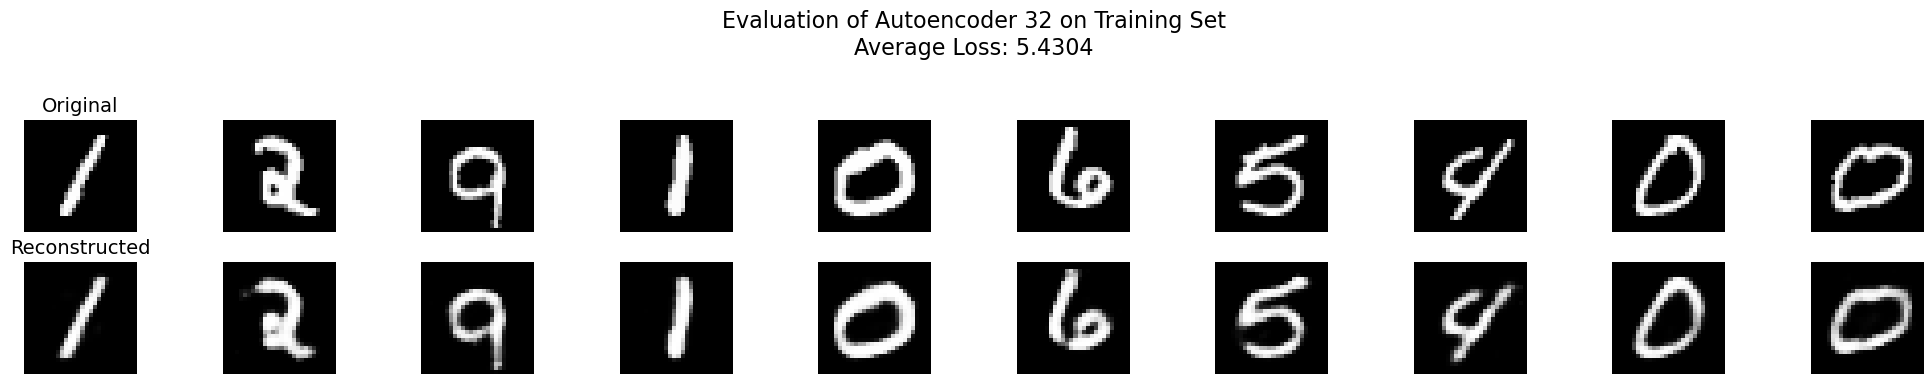

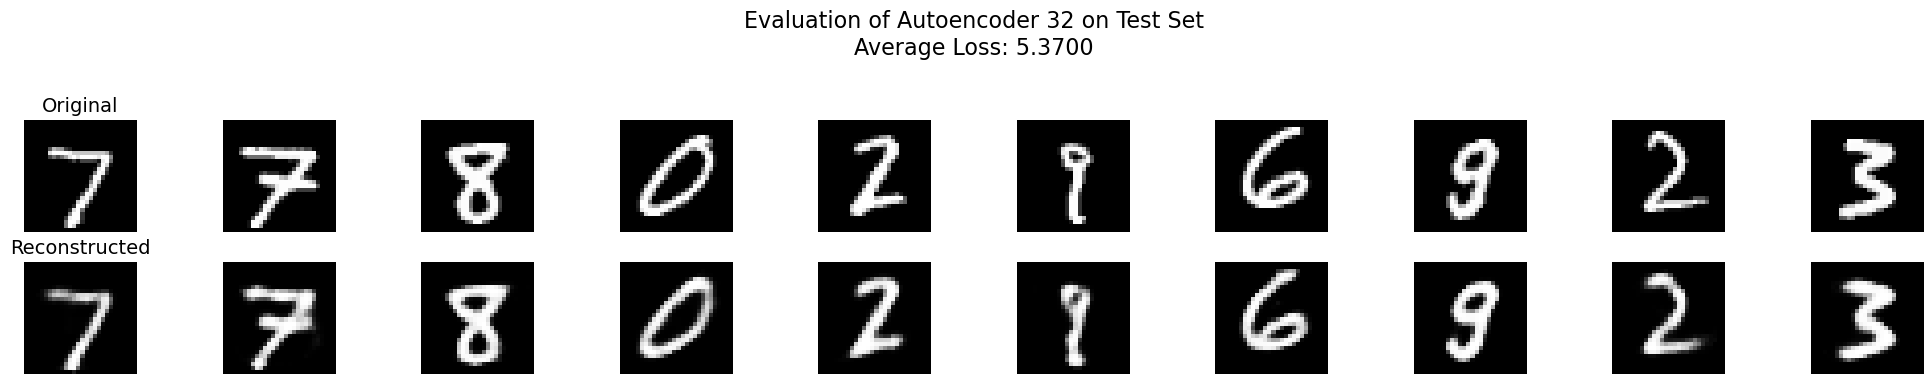

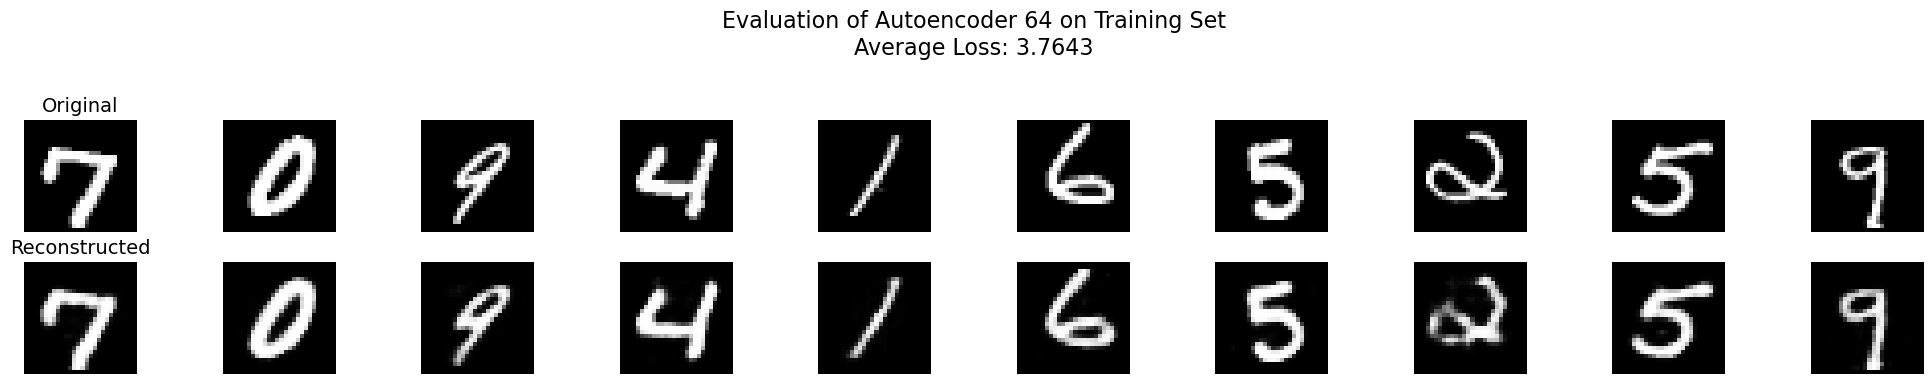

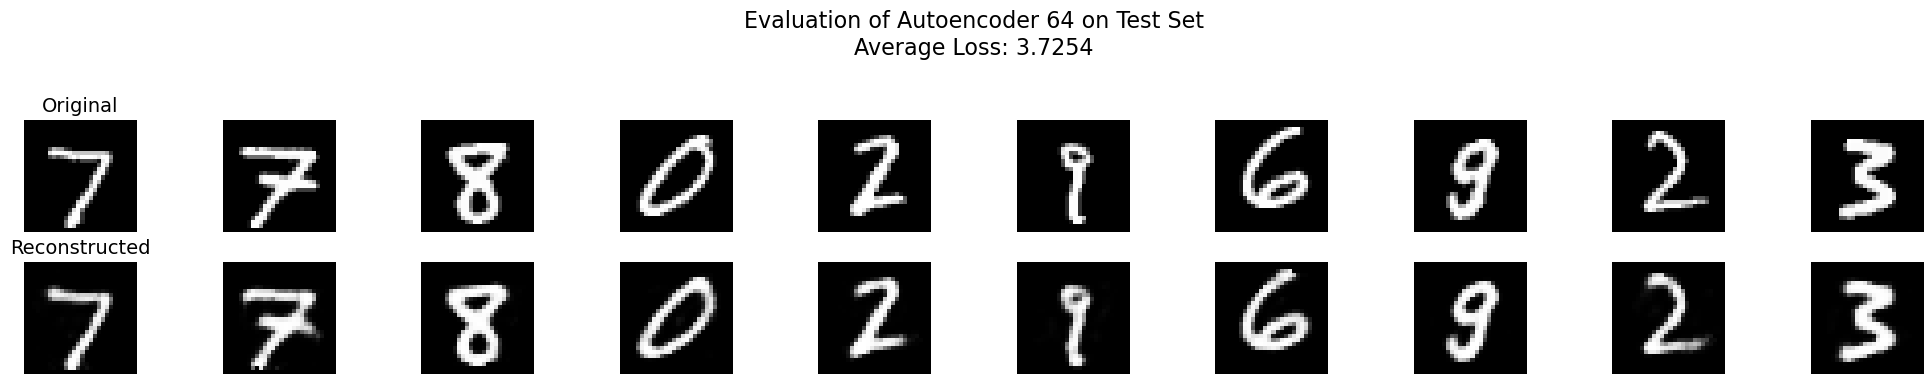

In [6]:
# Evaluate and visualize for both models
# For Autoencoder with 32-dimensional latent space
loss32_train = evaluate_and_visualize(ae32, train_loader, 'Autoencoder 32', 'Training Set')
loss32_test = evaluate_and_visualize(ae32, test_loader, 'Autoencoder 32', 'Test Set')

# For Autoencoder with 64-dimensional latent space
loss64_train = evaluate_and_visualize(ae64, train_loader, 'Autoencoder 64', 'Training Set')
loss64_test = evaluate_and_visualize(ae64, test_loader, 'Autoencoder 64', 'Test Set')



## Reconstruction on the line joining two training data samples

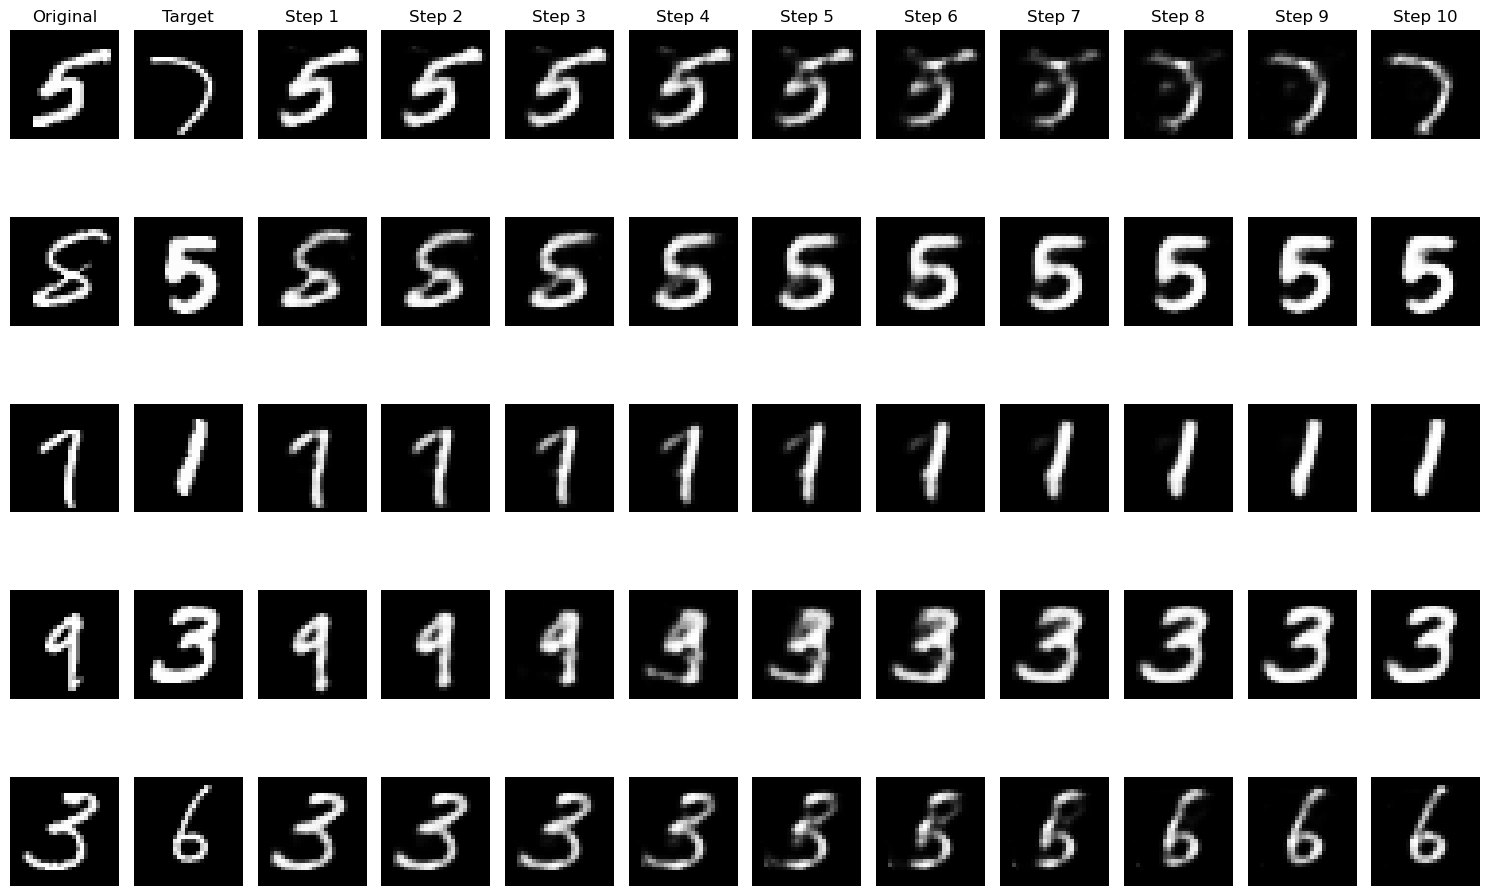

In [7]:
import matplotlib.pyplot as plt
import torch

def interpolate_points(model, data_loader, num_pairs=5, num_steps=10, figsize=(10, 2)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    try:
        data_iter = iter(data_loader)
        fig, axes = plt.subplots(num_pairs, num_steps + 2, figsize=(figsize[0], num_pairs * figsize[1]))

        for i in range(num_pairs):
            data1, _ = next(data_iter)
            data2, _ = next(data_iter)

            # Process only the first image in the batch for simplicity
            data1 = data1[0].to(device).view(-1, 28 * 28)  # First image of the batch
            data2 = data2[0].to(device).view(-1, 28 * 28)  # First image of the batch

            latent1 = model.encoder(data1)
            latent2 = model.encoder(data2)

            # Generate interpolation steps
            interpolation = torch.stack([latent1 + (latent2 - latent1) * t for t in torch.linspace(0, 1, steps=num_steps, device=device)])
            interpolated_images = model.decoder(interpolation).view(num_steps, 28, 28).cpu()

            # Display original and interpolated images
            axes[i, 0].imshow(data1.view(28, 28).cpu().numpy(), cmap='gray')
            axes[i, 0].set_title('Original' if i == 0 else '')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(data2.view(28, 28).cpu().numpy(), cmap='gray')
            axes[i, 1].set_title('Target' if i == 0 else '')
            axes[i, 1].axis('off')

            for step in range(num_steps):
                axes[i, step + 2].imshow(interpolated_images[step].detach().numpy(), cmap='gray')
                axes[i, step + 2].set_title(f'Step {step + 1}' if i == 0 else '')
                axes[i, step + 2].axis('off')

        plt.tight_layout()
        plt.show()

    except StopIteration:
        print("Not enough data in the DataLoader to generate the requested number of pairs.")

# Example call to the function
interpolate_points(ae32, train_loader, num_pairs=5, num_steps=10, figsize=(15, 2))


## Latent Space

In [8]:
def visualize_latent_space(model, data_loader, device, num_samples=1000):
    model.eval()
    model.to_device(device)  # Ensure the model is on the correct device

    # Collect latent vectors
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for i, (data, target) in enumerate(data_loader):
            if i * data_loader.batch_size > num_samples:
                break
            data = data.view(data.size(0), -1).to(device)  # Reshape and send data to device
            latent = model.encoder(data).cpu().numpy()  # Extract latent space and move to CPU
            latent_vectors.append(latent)
            labels.extend(target.numpy())
    
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # t-SNE transformation
    tsne = TSNE(n_components=2, random_state=123)
    tsne_results = tsne.fit_transform(latent_vectors)

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Latent Space Visualization Using t-SNE')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.grid(True)
    plt.show()



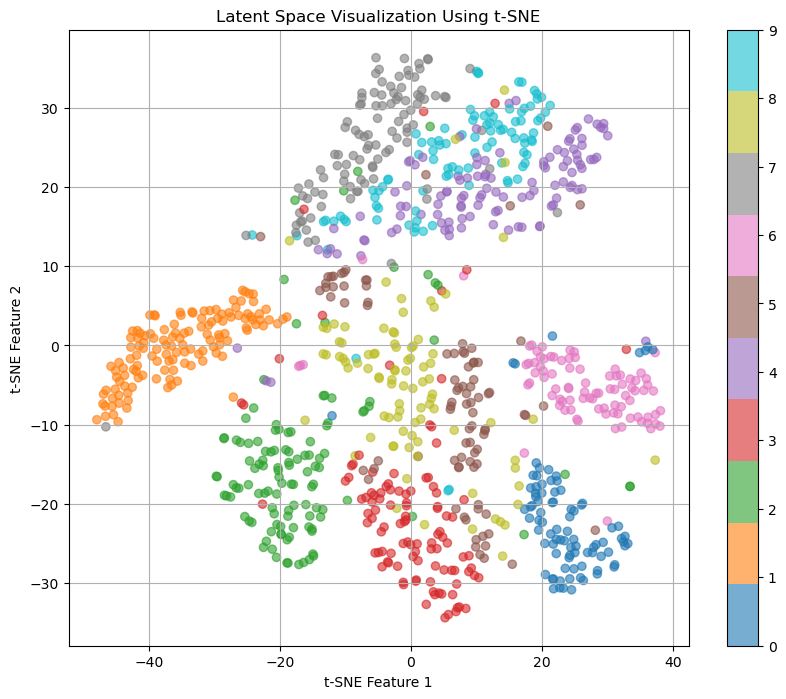

In [9]:
# Assuming 'model' is your Autoencoder instance and 'test_loader' is set up for MNIST
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_latent_space(ae64, test_loader, device)


# VAE

In [10]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 16)  # Means μ
        self.fc22 = nn.Linear(400, 16)  # Log of variance log σ²

        # Decoder
        self.fc3 = nn.Linear(16, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def to_device(self, device):
        self.to(device)
# Loss function for VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


## Training

In [11]:
def train(model, data_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for data, _ in data_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Average Loss: {train_loss / len(data_loader.dataset):.4f}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, train_loader, optimizer, epochs=30)


Epoch 1, Average Loss: 146.1356
Epoch 2, Average Loss: 116.4943
Epoch 3, Average Loss: 112.2457
Epoch 4, Average Loss: 110.1119
Epoch 5, Average Loss: 108.9380
Epoch 6, Average Loss: 108.0226
Epoch 7, Average Loss: 107.4405
Epoch 8, Average Loss: 106.8920
Epoch 9, Average Loss: 106.4568
Epoch 10, Average Loss: 106.0655
Epoch 11, Average Loss: 105.7985
Epoch 12, Average Loss: 105.5149
Epoch 13, Average Loss: 105.2595
Epoch 14, Average Loss: 105.0093
Epoch 15, Average Loss: 104.8379
Epoch 16, Average Loss: 104.5976
Epoch 17, Average Loss: 104.4538
Epoch 18, Average Loss: 104.2552
Epoch 19, Average Loss: 104.1551
Epoch 20, Average Loss: 103.9686
Epoch 21, Average Loss: 103.8656
Epoch 22, Average Loss: 103.7498
Epoch 23, Average Loss: 103.6385
Epoch 24, Average Loss: 103.4802
Epoch 25, Average Loss: 103.4344
Epoch 26, Average Loss: 103.3101
Epoch 27, Average Loss: 103.2132
Epoch 28, Average Loss: 103.1348
Epoch 29, Average Loss: 103.0621
Epoch 30, Average Loss: 102.9551


## Genreating the Sample Data From The VAE

In [12]:
def generate_sample(model, num_samples=64):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 16).to(device)
        samples = model.decode(z).cpu()
        return samples.view(-1, 28, 28)

samples = generate_sample(model)


## Ploting the sample data

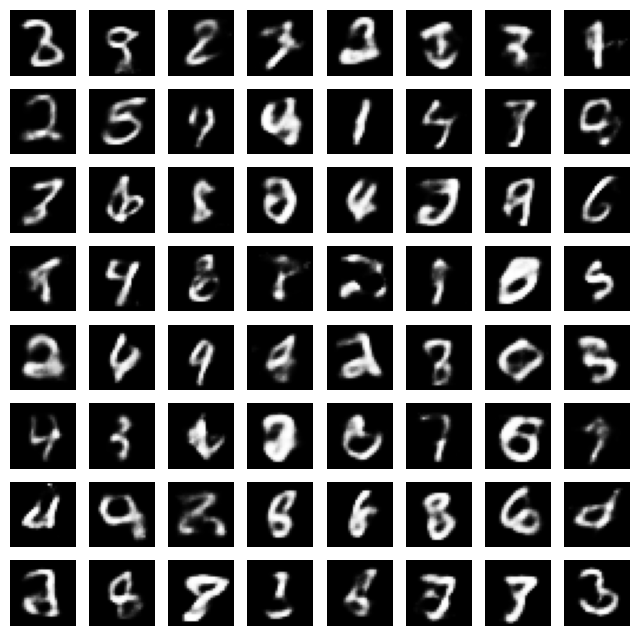

In [13]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.show()


## Latent Space

In [14]:
def visualize_latent_space_vae(vae_model, dataloader, device='cpu'):
    vae_model.eval()  # Set the model to evaluation mode
    vae_model.to(device)
    
    latent_vectors = []
    labels = []
    with torch.no_grad():  # No need to track gradients for visualization
        for data, target in dataloader:
            data = data.view(-1, 784).to(device)
            mu, logvar = vae_model.encode(data)
            z = vae_model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.append(target.numpy())

    # Concatenate all collected latent vectors and labels
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply t-SNE to reduce dimensions to two
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(latent_vectors)

    # Plot the t-SNE reduced latent vectors with labels
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, alpha=0.5, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of VAE Latent Space with MNIST Labels')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.294s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.194788
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.457367
[t-SNE] KL divergence after 300 iterations: 2.962910


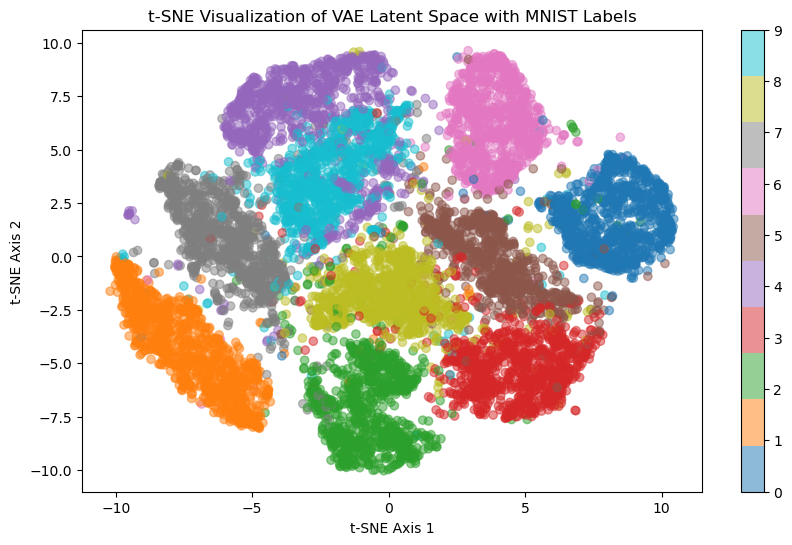

In [15]:
visualize_latent_space_vae(model, test_loader, device)